In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def eval_h(N, T, theta):
    '''
    This function calculates how many shares we should sell at each time step, based on a single parameter θ that controls how aggressively we sell. 
    It also keeps track of how sensitive those sell amounts are to changes in θ. 
    Basically, at each time step, we look at how many shares are still left and sell a fraction of that. 
    Since each decision depends on the previous ones, we also compute the chain of how each step’s decision is influenced by θ. 
    To keep things efficient, instead of summing from scratch every time, we just keep running totals of what’s been sold and how the derivatives accumulate. 
    In the end, we return both the sell schedule and its gradient with respect to θ, which we later use to optimize the policy.
    '''
    h = np.zeros(T + 2) 
    h_deriv = np.zeros(T + 2) 
    for t in range(1, T + 1):
        remaining = N - np.sum(h[:t])
        h[t] = theta * remaining
        h_deriv[t] = remaining - theta * np.sum(h_deriv[:t])
    return h, h_deriv

def eval_price_and_derivative(T, alpha, pi, p, h, h_deriv):
    '''
This function simulates how the stock price evolves over time as we execute our trades, and also tracks how sensitive that price path is to changes in θ. 
At each time step, we randomly determine one of three outcomes: 
either the price impact is based only on the current trade (no memory), it includes recent trades (memory), or no trade happens at all. 
Depending on the case, the price is updated using a nonlinear impact function that reduces the price as more shares are sold. 
At the same time, we compute how this price change responds to θ by using the chain rule and the derivatives of the trade amounts we calculated earlier. 
The function returns both the simulated price path and its gradient with respect to θ, which we’ll later use to compute the gradient of total revenue.
    '''
    price = np.ones(T + 1)
    price_deriv = np.zeros(T + 1)

    for t in range(1, T + 1):
        rnd = np.random.rand()
        if rnd < 1 - p:  # no memory
            ht = h[t]
            impact = max(0, 1 - alpha * ht ** pi)
            price[t] = price[t-1] * impact
            if impact > 0:
                price_deriv[t] = price_deriv[t-1] * impact + price[t-1] * (-alpha * pi * ht ** (pi - 1)) * h_deriv[t]

        elif rnd < 1 - 0.5 * p:  # memory
            hist = 0.25 * h[t-2] + 0.25 * h[t-1] + 0.5 * h[t]
            hist_deriv = 0.25 * h_deriv[t-2] + 0.25 * h_deriv[t-1] + 0.5 * h_deriv[t]
            impact = max(0, 1 - alpha * hist ** pi)
            price[t] = price[t-1] * impact
            if impact > 0:
                price_deriv[t] = price_deriv[t-1] * impact + price[t-1] * (-alpha * pi * hist ** (pi - 1)) * hist_deriv
        else:  # no trade
            price[t] = price[t-1]
            price_deriv[t] = price_deriv[t-1]

    return price, price_deriv

def simulate_trajectory(N, T, alpha, p, pi, theta):
    h, h_deriv = eval_h(N, T, theta)
    price, price_deriv = eval_price_and_derivative(T, alpha, pi, p, h, h_deriv)

    revenue = 0.0
    for t in range(1, T + 1):
        revenue += price[t] * h[t]

    gradient = sum(price_deriv[t] * h[t] + price[t] * h_deriv[t] for t in range(1, T + 1))
    return revenue, gradient

# Monte Carlo Gradient Ascent

def monte_carlo_gradient_ascent(N, T, alpha, p, pi, theta_init=0.3, learning_rate=1e-6, iterations=100, samples=1000):
    theta = theta_init
    theta_vals = []
    revenue_vals = []
    gradient_vals = []

    for i in range(iterations):
        total_revenue = 0.0
        total_gradient = 0.0

        for _ in range(samples):
            rev, grad = simulate_trajectory(N, T, alpha, p, pi, theta)
            total_revenue += rev
            total_gradient += grad

        avg_revenue = total_revenue / samples
        avg_gradient = total_gradient / samples
        avg_gradient = np.clip(avg_gradient, 0, 30000)

        theta += learning_rate * avg_gradient
        theta = np.clip(theta, 0.1, 0.9)

        theta_vals.append(theta)
        revenue_vals.append(avg_revenue)
        gradient_vals.append(avg_gradient)

        print(f"Iter {i+1:03d}: θ = {theta:.4f}, Revenue = {avg_revenue:.2f}, Gradient = {avg_gradient:.2f}")

    return theta_vals, revenue_vals, gradient_vals

# Run the optimizer

theta_hist, revenue_hist, grad_hist = monte_carlo_gradient_ascent(
    N=100000, T=20, alpha=0.001, p=0.25, pi=0.5,
    theta_init=0.3, learning_rate=1e-6, iterations=100, samples=10000
)

# Final evaluation of optimal theta
optimal_theta = theta_hist[-1]
final_revenues = [simulate_trajectory(N=100000, T=20, alpha=0.001, p=0.25, pi=0.5, theta=optimal_theta)[0] for _ in range(200)]
expected_revenue = np.mean(final_revenues)

print(f"\nOptimal theta: {optimal_theta:.4f}")
print(f"Expected revenue at optimal theta (averaged over 200 runs): {expected_revenue:.2f}")


Iter 001: θ = 0.3281, Revenue = 69420.22, Gradient = 28125.46
Iter 002: θ = 0.3523, Revenue = 70185.37, Gradient = 24131.16
Iter 003: θ = 0.3737, Revenue = 70694.73, Gradient = 21399.95
Iter 004: θ = 0.3928, Revenue = 71061.50, Gradient = 19128.82
Iter 005: θ = 0.4103, Revenue = 71600.23, Gradient = 17522.67
Iter 006: θ = 0.4262, Revenue = 71706.05, Gradient = 15867.85
Iter 007: θ = 0.4410, Revenue = 72022.33, Gradient = 14852.15
Iter 008: θ = 0.4547, Revenue = 72177.30, Gradient = 13654.74
Iter 009: θ = 0.4679, Revenue = 72486.01, Gradient = 13182.24
Iter 010: θ = 0.4801, Revenue = 72660.83, Gradient = 12247.68
Iter 011: θ = 0.4917, Revenue = 72681.78, Gradient = 11544.72
Iter 012: θ = 0.5028, Revenue = 72987.36, Gradient = 11098.08
Iter 013: θ = 0.5132, Revenue = 73020.87, Gradient = 10426.18
Iter 014: θ = 0.5230, Revenue = 73076.08, Gradient = 9805.76
Iter 015: θ = 0.5324, Revenue = 73225.86, Gradient = 9458.03
Iter 016: θ = 0.5415, Revenue = 73310.21, Gradient = 9010.23
Iter 017: θ

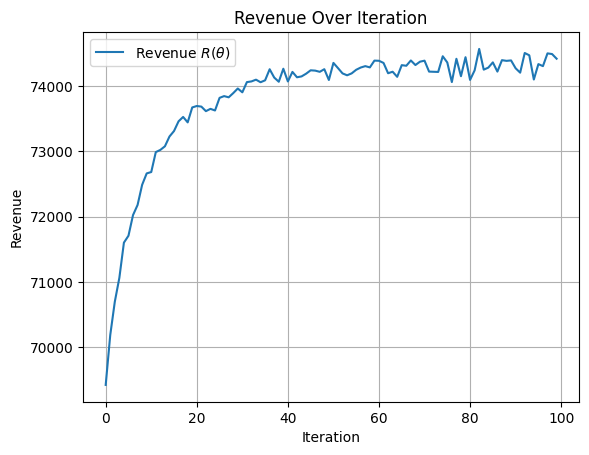

In [29]:
plt.plot(revenue_hist, label='Revenue $R(θ)$')
plt.title("Revenue Over Iteration")
plt.xlabel("Iteration")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)

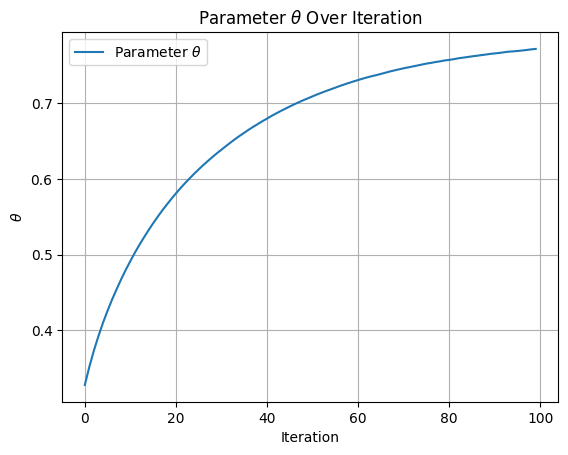

In [32]:
plt.plot(theta_hist, label='Parameter $θ$')
plt.title("Parameter $θ$ Over Iteration")
plt.xlabel("Iteration")
plt.ylabel("$θ$")
plt.legend()
plt.grid(True)

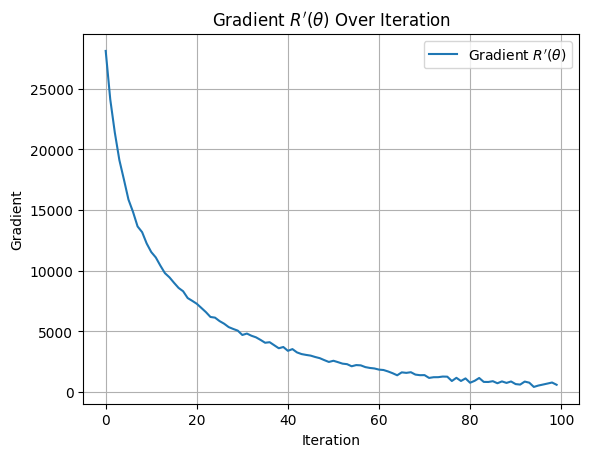

In [33]:
plt.plot(grad_hist, label="Gradient $R'(θ)$")
plt.title("Gradient $R'(θ)$ Over Iteration")
plt.xlabel("Iteration")
plt.ylabel("Gradient")
plt.legend()
plt.grid(True)

### Task 2 – Dynamic Programming Formulation

In Task 2, we aim to maximize expected total revenue by optimally deciding how many shares to sell in each period, instead of following a fixed policy. We model this problem using dynamic programming.

We define the state as a pair **(k, t)**, where **k** is the number of shares remaining at time **t**. The decision at each state is how many shares **h** to sell, where **0 ≤ h ≤ k**. The value function **R(k, t)** represents the maximum expected revenue from period **t** onward, starting with **k** shares.

The recursive relationship is:
$$
R(k, t, h_{t-1}, h_{t-2}) = \max_{0 \le h \le k} \left\{ \mathbb{E}[\text{Revenue}(h, t)] + R(k - h, t+1, h, h_{t-1}) \right\}
$$

The expectation $E[ Revenue(h, t) + R(k - h, t+1) ]$ accounts for three possible scenarios:
1. **No-memory price impact** (probability **1 - p**):  
   Price multiplier: $\max(0, 1 - \alpha h^\pi)$

2. **Memory-based impact** (probability **0.5p**):  
   Price multiplier: $\max(0, 1 - \alpha (0.25 h_{t-2} + 0.25 h_{t-1} + 0.5 h)^\pi)$

3. **Failed transaction** (probability **0.5p**):  
   Revenue = 0, and inventory remains unchanged.

Thus, the expected immediate revenue is:

$$
\begin{aligned}
\mathbb{E}[\text{Revenue}(h, t)] =\ & (1 - p) \cdot h \cdot \left(1 - \alpha h^{\pi} \right)_+ \\
&+ \frac{p}{2} \cdot h \cdot \left(1 - \alpha (0.25 h_{t-2} + 0.25 h_{t-1} + 0.5 h)^{\pi} \right)_+
\end{aligned}
$$

At the terminal period $t = T$, the value function simplifies to:

$$
R(k, T, h_{T-1}, h_{T-2}) = \max_{0 \le h \le k} \mathbb{E}[\text{Revenue}(h, T)]
$$

The algorithm proceeds via **backward induction**, starting from **t = T** down to **t = 1**, and at each step selects the **h** that maximizes the expected revenue.

